# Modal American: A Clustering Analysis
This document is inspired by the work done by Planet Money in their [Episode 936: The Modal American](https://www.npr.org/2019/08/28/755191639/episode-936-the-modal-american). The premise of the episode was to identify the most "modal" american, that is, to fnd the traits that comprise the typical American. This is not to be confused with a list of averages for the entire US population, but rather a description of a hypothetical singular individual that shares traits with the most people. 

In their original analysis, Planet Money used used a methodolgy of binning individual traits for each person and counting each person with the same bin signature. I wanted to do a *data science* approach using *clustering algorithms* to see if I could recreate similar results to the binning method. The advantages to this approach are that that I can analyze and cluster Americans across continuous data, which should theoretically yield more representative results than binning.

Below, I've detailed the steps for how I went about performing this analysis. Scroll down to the bottom to view the results of clustering and how they compared to Planet Money's.

## Methodology
### The Advantages of Clustering
Becuase of the binning approach that Planet Money used, they can get a hard count on the number of Americans that share characteristics in each bin. However, when you resort to strictly counting, you lose the ability to capture similarity in your clusters. Take, for example, two Americans who are identical in every trait except age. One is 36, while the other is 37. With PM's analysis, these two individuals are considered "diferent" (Millenial vs. Gen-X), and are treated as distinct for the purposes of calculating the "modal American". With a clustering-based approach, the similarity of a 36 vs 37 year old is considered greater than that of a 36 vs 70 year old, which I believe is an important distinction to make in this analysis. 

For categorical data that cannot be measured on a continuous axis, I performed one-hot encoding to break up these traits into individual presence/absence features and performed traditional clustering along these new dimensions. Because each category gets its own dimension to be used for clustering, this essentially equates the similarity between a Single and Married person as the same as the similarity between the youngest and oldest American, which some may disagree with. This is a limitiation that I have decided to work with; introducing similarity scores between features would introduce an level of subjectivity that I don't feel is appropriate for this analysis. 

### Prepping the Data
In the orignal PM analysis, they used 8 characteristics to group Americans: age, race and ethnicity, sex, neighborhood type, marital status, education, household income, and employment status. In order to obtain this census data, I used the the [IPUMS](https://usa.ipums.org/usa/) dataset. In my query to IPUMS, I selected the following variables:

- YEAR 
- SAMPLE
- SERIAL
- CBSERIAL
- HHWT 
- PUMA 
- GQ 
- PERNUM 
- PERWT 
- SEX 
- AGE
- MARST
- RACE 
- RACED 
- EDUC 
- EDUCD 
- EMPSTAT 
- EMPSTATD 
- FTOTINC

Once my extract was prepard, I downloaded it and modified the provided R script to unpack the data into csv format 

Add the following to the R script: `write.csv(data, file = "census.csv")`

I'll use the following software packages to do my analysis. These are all packages included in the base [Anaconda](https://www.anaconda.com/) distribution.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import time

Let's start by loading in the IPUMS data. Here's what it looks like in raw form imported with Pandas

In [2]:
data = pd.read_csv('./data/census.csv').drop(columns='Unnamed: 0')
data.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,PUMA,GQ,PERNUM,PERWT,SEX,AGE,MARST,RACE,RACED,EDUC,EDUCD,EMPSTAT,EMPSTATD,FTOTINC
0,2017,201701,1.0,2.017000e+12,206,2500,1,1,206,1,73,3,2,200,2,25,3,30,10000.0
1,2017,201701,2.0,2.017000e+12,45,1800,1,1,45,2,31,6,1,100,10,101,1,10,38500.0
2,2017,201701,3.0,2.017000e+12,136,2400,1,1,136,1,41,1,1,100,6,64,1,10,90700.0
3,2017,201701,3.0,2.017000e+12,136,2400,1,2,121,2,48,1,1,100,6,63,3,30,90700.0
4,2017,201701,3.0,2.017000e+12,136,2400,1,3,111,1,16,6,1,100,4,40,3,30,90700.0


In order to analyze neighborhood type category, we need to calculate [tract-weighted average density](http://jedkolko.com/2017/05/22/climbing-sprawling-methodology/) for each PUMA, [simlarly to what PM did](https://www.npr.org/2019/08/28/755191639/episode-936-the-modal-american). This is done by taking the ratio of the total population residing in each PUMA to the number of unique addresses assigned to the PUMA. With this approach, we get a nice, continuous dimensionality to add to our dataset.

In [3]:
puma_total_population = data['PUMA'].value_counts()
puma_addresses = data.groupby('PUMA')['SERIAL'].nunique()
puma_density = puma_total_population/puma_addresses
data['PUMA_TRACT_DENSITY'] = data['PUMA'].map(puma_density)
data.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,PUMA,GQ,PERNUM,PERWT,SEX,AGE,MARST,RACE,RACED,EDUC,EDUCD,EMPSTAT,EMPSTATD,FTOTINC,PUMA_TRACT_DENSITY
0,2017,201701,1.0,2.017000e+12,206,2500,1,1,206,1,73,3,2,200,2,25,3,30,10000.0,2.263719
1,2017,201701,2.0,2.017000e+12,45,1800,1,1,45,2,31,6,1,100,10,101,1,10,38500.0,2.206161
2,2017,201701,3.0,2.017000e+12,136,2400,1,1,136,1,41,1,1,100,6,64,1,10,90700.0,2.232037
3,2017,201701,3.0,2.017000e+12,136,2400,1,2,121,2,48,1,1,100,6,63,3,30,90700.0,2.232037
4,2017,201701,3.0,2.017000e+12,136,2400,1,3,111,1,16,6,1,100,4,40,3,30,90700.0,2.232037


Here's a look at what the PUMA_TRACT_DENSITY looks like when plotted on a histogram. Neat! It looks like a lognormal distribution! 

(array([  2561.,   1055.,   1252.,   1894.,  11394.,  14693.,  10379.,
         17197.,  29891.,  35351.,  54231., 115798., 115182., 573711.,
        717466., 328144., 225089., 150544., 123202., 100232.,  89631.,
         71580.,  53073.,  54645.,  57113.,  38219.,  33221.,  32300.,
         33649.,  11643.,  16643.,   8595.,   4501.,   7422.,   8087.,
           951.,  10859.,   2052.,   5638.,   5762.,   2479.,   2011.,
          1212.,   2899.,   2103.,      0.,      0.,   1502.,   1397.,
          1587.]),
 array([1.53392857, 1.58123526, 1.62854194, 1.67584863, 1.72315532,
        1.770462  , 1.81776869, 1.86507538, 1.91238206, 1.95968875,
        2.00699544, 2.05430212, 2.10160881, 2.1489155 , 2.19622218,
        2.24352887, 2.29083556, 2.33814224, 2.38544893, 2.43275562,
        2.4800623 , 2.52736899, 2.57467568, 2.62198236, 2.66928905,
        2.71659574, 2.76390242, 2.81120911, 2.8585158 , 2.90582248,
        2.95312917, 3.00043585, 3.04774254, 3.09504923, 3.14235591,
        

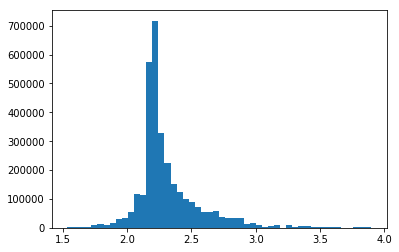

In [4]:
plt.hist(data['PUMA_TRACT_DENSITY'], bins = 50)

In order to cluster the categorical data (sex, race/ethnicity, neighborhood type, marital status, education, employment status), I perfomed one-hot encoding on categorical data to generate relevant columns for clustering

In [5]:
categorical_vars = ['SEX', 'RACE', 'MARST', 'EDUC', 'EMPSTAT']
data = pd.get_dummies(data, columns=categorical_vars)
data.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,PUMA,GQ,PERNUM,PERWT,AGE,...,EDUC_5,EDUC_6,EDUC_7,EDUC_8,EDUC_10,EDUC_11,EMPSTAT_0,EMPSTAT_1,EMPSTAT_2,EMPSTAT_3
0,2017,201701,1.0,2.017000e+12,206,2500,1,1,206,73,...,0,0,0,0,0,0,0,0,0,1
1,2017,201701,2.0,2.017000e+12,45,1800,1,1,45,31,...,0,0,0,0,1,0,0,1,0,0
2,2017,201701,3.0,2.017000e+12,136,2400,1,1,136,41,...,0,1,0,0,0,0,0,1,0,0
3,2017,201701,3.0,2.017000e+12,136,2400,1,2,121,48,...,0,1,0,0,0,0,0,0,0,1
4,2017,201701,3.0,2.017000e+12,136,2400,1,3,111,16,...,0,0,0,0,0,0,0,0,0,1


Extract only the relevant columns from the dataframe and standardize the data. Standardization is needed because how dissimilar some of the features are (household income)

In [6]:
relevant_data = data.filter(regex='AGE|RACE_|SEX|PUMA_TRACT_DENSITY|MARST|EDUC_|FTOTINC|EMPSTAT_')
relevant_data.head()

,AGE,FTOTINC,PUMA_TRACT_DENSITY,SEX_1,SEX_2,RACE_1,RACE_2,RACE_3,RACE_4,RACE_5,...,EDUC_5,EDUC_6,EDUC_7,EDUC_8,EDUC_10,EDUC_11,EMPSTAT_0,EMPSTAT_1,EMPSTAT_2,EMPSTAT_3
0,73,10000.0,2.263719,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,31,38500.0,2.206161,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,41,90700.0,2.232037,1,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,48,90700.0,2.232037,0,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,16,90700.0,2.232037,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [7]:
scaler = StandardScaler()
scaler.fit(relevant_data)
scaled_data = scaler.transform(relevant_data)

C:\Users\atran39\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\atran39\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


## Clustering
We start the actual clustering. I wanted to use [K-means](https://scikit-learn.org/stable/modules/clustering.html#k-means), the traditional clustering algorithm, due to its quick runtime over very large datasets such as US Census data. The only issue with using K-means is that you need to supply a *K* number of clusters to allocate centroids.To get an approximation at the total number of clusters, I used [DSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), which can identify and ennumerate high density clusters. Becuase DBSCAN has a high runtime for such a large dataset, I opted to run DBSCAN multiple times on smaller, randomly smapled proportions of the original census data to extract what are hopefully meaningful numbers of clusters to provide to the K-means algorithm.

In [8]:
runs = 3
num_clusters_list = []
sample_ratio = .1
dbscan_min_samples = 500

time_flag = True # use this to measure the time to run DBSCAN for each sample run, for me it was ~10,000s (3hr) per iteration using the above parameters

if time_flag:
    t0 = time.time()

for _ in range(runs):
    num_samples = int(sample_ratio * scaled_data.shape[0])
    samples = scaled_data[np.random.choice(scaled_data.shape[0], num_samples, replace=True)]
    db = DBSCAN(min_samples=dbscan_min_samples).fit(samples)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    num_clusters_list.append(n_clusters_)
    
    if time_flag:
        t1 = time.time()
        delta = t1 - t0
        t0 = t1
        print('trial time:', delta)
        
print('num_clusters_list:', num_clusters_list)
optimal_n = int(np.rint(np.mean(num_clusters_list)))

trial time: 9124.959834337234
trial time: 9051.583791255951
trial time: 9180.055599689484
num_clusters_list: [52, 53, 54]


In [9]:
optimal_n

53

In [10]:
kmeans = KMeans(n_clusters=optimal_n).fit(scaled_data)
labels, counts = np.unique(kmeans.labels_, return_counts=True)

Lets have a look at the unscaled data to see what the largest clusters look like

In [11]:
num_clusters = optimal_n

largest_clusters_indexes = np.argsort(-counts[:num_clusters])
largest_cluster_centriods = kmeans.cluster_centers_[largest_clusters_indexes]
cluster_centriods_rescaled = pd.DataFrame(data=scaler.inverse_transform(largest_cluster_centriods), columns=relevant_data.columns)
cluster_centriods_rescaled['cluster_size'] = counts[largest_clusters_indexes]
cluster_centriods_rescaled.head()

,AGE,FTOTINC,PUMA_TRACT_DENSITY,SEX_1,SEX_2,RACE_1,RACE_2,RACE_3,RACE_4,RACE_5,...,EDUC_6,EDUC_7,EDUC_8,EDUC_10,EDUC_11,EMPSTAT_0,EMPSTAT_1,EMPSTAT_2,EMPSTAT_3,cluster_size
0,49.964541,95870.003201,2.296094,5.945353e-01,0.405465,1.000000,2.180200e-13,-1.069630e-14,-2.892478e-14,3.138982e-15,...,9.756391e-01,1.325606e-13,-1.748879e-13,3.575751e-13,3.543554e-13,0.000010,9.999901e-01,-2.508063e-14,2.451372e-13,201824
1,15.142687,233097.409854,2.330388,5.244815e-01,0.475518,0.882440,1.175598e-01,-4.151887e-14,3.133604e-14,2.937321e-15,...,2.543521e-13,2.430139e-13,2.155220e-14,-2.065292e-13,1.306039e-13,0.905891,6.448023e-02,-2.414735e-14,2.962894e-02,140186
2,75.966496,946575.037067,2.276936,2.143034e-01,0.785697,0.900717,9.891205e-02,-4.050406e-14,3.289383e-14,2.924744e-15,...,5.346094e-01,1.292962e-01,4.765610e-02,1.190784e-01,7.425858e-02,0.000015,1.577531e-01,-2.408837e-14,8.422323e-01,137506
3,3.889300,208683.894704,2.317942,5.154014e-01,0.484599,0.878749,1.212514e-01,-3.855770e-14,3.243066e-14,2.900024e-15,...,1.270095e-13,2.088607e-13,5.781486e-14,-2.041423e-13,8.930356e-14,0.953981,2.511249e-02,-2.397388e-14,2.090697e-02,132684
4,62.317395,69775.404364,2.295207,5.708767e-13,1.000000,1.000000,1.691147e-13,-2.396694e-14,2.896121e-14,2.716577e-15,...,9.143638e-01,4.064804e-14,7.399636e-14,-1.923461e-13,-1.142142e-13,0.000019,9.230394e-13,-2.312733e-14,9.999810e-01,105045


This is pretty difficult to read, so I wrote a function to decode the data encoded in the columns.

I also decoded neighborhood density in accordance with PM's analysis so that density was aligned with the results in [this survey](https://fivethirtyeight.com/features/how-suburban-are-big-american-cities/).

### Results

In [12]:
soup = BeautifulSoup(open('./data/usa_00001.xml'), 'xml')
pattern = r'(?P<cat>\w*)_(?P<encoding>\d+)'

# Nationally, 26 percent of Americans described where they live as urban, 53 percent said suburban and 21 percent said rural.
density_classification_ratios = [.21, .74, 1]
sorted_pumas = data['PUMA_TRACT_DENSITY'].sort_values()
density_classification_cutoffs = [
    sorted_pumas.iloc[int(density_classification_ratios[0]*sorted_pumas.size-1)],
    sorted_pumas.iloc[int(density_classification_ratios[1]*sorted_pumas.size-1)],
    sorted_pumas.iloc[int(density_classification_ratios[2]*sorted_pumas.size-1)],    
]
density_classification_labels = ['RURAL', 'SUBURBAN', 'URBAN']

def map_column_to_name(column_name):
    regex_result = re.match(pattern, column_name)
    category = regex_result.group('cat')
    cur_soup = soup.dataDscr.find('var', {'ID': category})
    # translate encoded category to english
    cat_valu_encoding = regex_result.group('encoding')
    for soup_catgry in cur_soup.find_all('catgry'):
        if int(soup_catgry.catValu.string) == int(cat_valu_encoding):
            return soup_catgry.labl.string

def translate_tract_density(density):
    for i in range(len(density_classification_cutoffs)):
        if density < density_classification_cutoffs[i]:
            return density_classification_labels[i]
    return density_classification_labels[2]
            
#returns dataframe of decoded values
def cluster_decoder(cluster): # cluster needs to be df rescaled to original scale
    attributes = ['AGE','RACE','SEX','PUMA_TRACT_DENSITY','MARST','EDUC','FTOTINC','EMPSTAT', 'cluster_size']
#     categorical_vars = ['SEX', 'RACE', 'MARST', 'EDUC', 'EMPSTAT']
    decoded_df = pd.DataFrame(columns=attributes)
    
    for attr in attributes:
        if attr in categorical_vars:
            encoded_cols_df = cluster.filter(like=attr)
            max_indexes = encoded_cols_df.idxmax(axis=1)
            # map maxes to english
            decoded_df[attr] = max_indexes.apply(map_column_to_name)
        elif attr == 'PUMA_TRACT_DENSITY':
            decoded_df[attr] = cluster[attr].apply(translate_tract_density)
        else:
            decoded_df[attr] = cluster[attr]
    return decoded_df
    
cluster_decoder(cluster_centriods_rescaled)

,AGE,RACE,SEX,PUMA_TRACT_DENSITY,MARST,EDUC,FTOTINC,EMPSTAT,cluster_size
0,49.964541,White,Male,SUBURBAN,"Married, spouse present",Grade 12,9.587000e+04,Employed,201824
1,15.142687,White,Male,SUBURBAN,Never married/single,"Grade 5, 6, 7, or 8",2.330974e+05,N/A,140186
2,75.966496,White,Female,SUBURBAN,Widowed,Grade 12,9.465750e+05,Not in labor force,137506
3,3.889300,White,Male,SUBURBAN,Never married/single,N/A or no schooling,2.086839e+05,N/A,132684
4,62.317395,White,Female,SUBURBAN,"Married, spouse present",Grade 12,6.977540e+04,Not in labor force,105045
5,47.808381,White,Male,SUBURBAN,"Married, spouse present",4 years of college,1.627681e+05,Employed,93279
6,51.507966,White,Female,SUBURBAN,Divorced,Grade 12,7.136696e+04,Employed,88506
7,7.773693,White,Male,SUBURBAN,Never married/single,Nursery school to grade 4,1.824855e+05,N/A,85013
8,45.196549,White,Female,SUBURBAN,"Married, spouse present",4 years of college,1.518106e+05,Employed,84091
9,7.815222,White,Female,SUBURBAN,Never married/single,Nursery school to grade 4,1.713651e+05,N/A,80935


## Takeaways
We can see from the above dataframe of some of the largest clusters that comprise the US population. Results from clustering look slightly different from Planet Money, who found the following results

| rank | AGE | RACE | SEX | PUMA_TRACT_DENSITY | MARST | EDUC | FTOTINC | EMPSTAT | count |
| ---- | --- | ---- | --- |  ----------------- | ----- | ---- | ------- | ------- | ----- |
| 0 | Gen X (39-54) | white | male | suburban | married | did not complete a bachelor's degree | 75,000-165,000 | working full time | ~2 million |
| 1 | baby-boomer (53-71) | white | female | suburban | married | did not complete a bachelor's degree | 30,000-75,000 | not working |  ~2 million |

The clustering results look slightly different from the binning results. For one thing, we see that the largest clusters are smaller than the largest bins, ~200,000 vs 200 million. This can be attributed to the clusters breaking out the largest bin into several subgroups. Another interesting thing about the clustering results was that while binning had the issue of overgrouping young children, which Planet Money had to filter out, clustering was able to naturally filter them out. This was because cluster centroids achieve better fit over data when centered around median values and so naturally filtered out children as being less common to the modal American.  

Overall, I'm happy to see that the results obtained from clustering were comparable to that of Planet Money's. Hopefully, being able to see who the most "typical" Americans are is useful when thinking about the different types of people who comprise of American society, and be sure to listen to the [podcast episode](https://www.npr.org/2019/08/28/755191639/episode-936-the-modal-american) to hear more about the policy implications of this information. 